<a href="https://colab.research.google.com/github/brenoakihiromorimoto/portf-lio/blob/main/%237DaysOfCode/dia_3_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#7DaysOfCode - Ciência de Dados 3/7: Forecasting

É hora de encarar o terceiro dia de desafio!

E como você já viu, a tarefa hoje é: Forecasting. Vou te explicar melhor o que é isso.

O trabalho de um Cientista de Dados geralmente gira em torno de duas principais frentes: descrição (entender o que aconteceu e por que aconteceu) e predição (prever o que pode acontecer e o que deve ser feito).

É provável que ontem você tenha aplicado algumas dessas técnicas descritivas, utilizando análise de dados e visualizações para entender o que aconteceu.

Neste caso, você analisou o que aconteceu com os gastos dos senadores.

Para as tarefas de predição, são utilizadas técnicas de Machine Learning e ferramentas estatísticas para prever o futuro. E é sobre elas que falaremos hoje.

Forecasting é uma das técnicas mais conhecidas e utilizadas por Data Scientists para prever indicadores de negócios.

Por exemplo: uma área de Finanças pode querer que você preveja o faturamento da empresa; ou então seu time de Marketing pode querer prever quantos usuários irão se cadastrar na plataforma nos próximos meses.

No desafio de hoje, eu quero te provocar a criar o seu próprio modelo de Forecasting!

Será que você consegue criar um modelo que irá prever quanto os senadores vão gastar nos próximos três meses?

Você ainda utilizará o dataset do CEAPS que utilizou ontem, mas será muito importante para o seu modelo que você tenha mais de um ano de dados.

Os dados do CEAPS são divididos por ano, então seria interessante pegar pelo menos quatro anos e juntar em um grande dataset (isso fará seu modelo mais preciso).

Mas, se você não tem tempo pra isso, não tem problema. Eu já fiz um dataset para esse desafio, que você pode baixar aqui. Esse dataset contém dados de 2018 a 2021 do CEAPS, e nele você encontrará duas colunas:

DS, que representa a data do reembolso; 
Y, que é a soma de reembolsos dos senadores naquele dia.

# Importar Bibliotecas

In [571]:
from google.colab import drive
drive.mount('/gdrive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from datetime import datetime
import datetime
!pip install prophet
from prophet import Prophet


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Importar Dataset feito no dia 1.

In [572]:
link = "/gdrive/MyDrive/Colab Notebooks/#7DaysOfCode/"

despesa_ceaps_full = pd.read_csv(link+"despesa_ceaps_full.csv", sep=',')

despesa_ceaps_full = despesa_ceaps_full.drop('Unnamed: 0', axis=1)

In [573]:
despesa_ceaps_full.columns

Index(['ANO', 'MES', 'SENADOR', 'TIPO_DESPESA', 'CNPJ_CPF', 'FORNECEDOR',
       'DATA', 'DETALHAMENTO', 'VALOR_REEMBOLSADO', 'SEM_DOCUMENTO',
       'SEM_DETALHAMENTO', 'DIA'],
      dtype='object')

In [574]:
despesa_ceaps_full.head(3)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,SEM_DOCUMENTO,SEM_DETALHAMENTO,DIA
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/01/2019,Despesa com pagamento de energia elétrica do e...,66.020,0.000,0.000,4
1,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/01/2019,Despesa com pagamento de energia elétrica do e...,139.980,0.000,0.000,4
2,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,07/01/2019,Despesa com pagamento de aluguel de imóvel par...,6000.000,0.000,0.000,7


# Pré-Processamento para Forecasting

In [575]:
datetime_despesa_ceaps_full = pd.DataFrame({'year': despesa_ceaps_full['ANO'].tolist(), 
                                            'month': despesa_ceaps_full['MES'].tolist(), 
                                            'day': despesa_ceaps_full['DIA'].tolist()})

In [576]:
datetime_despesa_ceaps_full['datetime'] = np.nan
for i in range(len(datetime_despesa_ceaps_full['datetime'])):
  datetime_despesa_ceaps_full['datetime'][i] = datetime.datetime(datetime_despesa_ceaps_full['year'].astype(int)[i],
                                                      datetime_despesa_ceaps_full['month'].astype(int)[i],
                                                      datetime_despesa_ceaps_full['day'].astype(int)[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [577]:
datetime_despesa_ceaps_full[['datetime', 'year', 'month']].sort_values(by='datetime')

,datetime,year,month
9127,2019-01-01 00:00:00,2019,1
11494,2019-01-01 00:00:00,2019,1
1128,2019-01-01 00:00:00,2019,1
1127,2019-01-01 00:00:00,2019,1
1126,2019-01-01 00:00:00,2019,1
...,...,...,...
54619,2022-04-07 00:00:00,2022,4
54871,2022-04-08 00:00:00,2022,4
54872,2022-04-11 00:00:00,2022,4
54873,2022-04-11 00:00:00,2022,4


In [578]:
despesa_ceaps_full['datetime'] = datetime_despesa_ceaps_full['datetime']

In [579]:
despesa_ceaps_full[['datetime', 'VALOR_REEMBOLSADO']].sort_values(by='datetime')

,datetime,VALOR_REEMBOLSADO
9127,2019-01-01 00:00:00,156.470
11494,2019-01-01 00:00:00,2000.000
1128,2019-01-01 00:00:00,333.300
1127,2019-01-01 00:00:00,200.310
1126,2019-01-01 00:00:00,102.010
...,...,...
54619,2022-04-07 00:00:00,56.220
54871,2022-04-08 00:00:00,371.700
54872,2022-04-11 00:00:00,940.000
54873,2022-04-11 00:00:00,187.240


In [580]:
despesa_ceaps_full_forecasting = despesa_ceaps_full[['datetime', 'VALOR_REEMBOLSADO']].sort_values(by='datetime')

In [581]:
despesa_ceaps_full_forecasting

,datetime,VALOR_REEMBOLSADO
9127,2019-01-01 00:00:00,156.470
11494,2019-01-01 00:00:00,2000.000
1128,2019-01-01 00:00:00,333.300
1127,2019-01-01 00:00:00,200.310
1126,2019-01-01 00:00:00,102.010
...,...,...
54619,2022-04-07 00:00:00,56.220
54871,2022-04-08 00:00:00,371.700
54872,2022-04-11 00:00:00,940.000
54873,2022-04-11 00:00:00,187.240


In [582]:
despesa_ceaps_full_forecasting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56281 entries, 9127 to 55117
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   datetime           56281 non-null  object 
 1   VALOR_REEMBOLSADO  56281 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.3+ MB


In [583]:
despesa_ceaps_full

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,SEM_DOCUMENTO,SEM_DETALHAMENTO,DIA,datetime
0,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/01/2019,Despesa com pagamento de energia elétrica do e...,66.020,0.000,0.000,4,2019-01-04 00:00:00
1,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/01/2019,Despesa com pagamento de energia elétrica do e...,139.980,0.000,0.000,4,2019-01-04 00:00:00
2,2019,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,07/01/2019,Despesa com pagamento de aluguel de imóvel par...,6000.000,0.000,0.000,7,2019-01-07 00:00:00
3,2019,12,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.423.963/0001-11,OI MÓVEL S.A.,25/12/2019,Despesa com pagamento de telefonia para o escr...,316.390,0.000,0.000,25,2019-12-25 00:00:00
4,2019,2,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,04/02/2019,Despesa com pagamento de energia elétrica para...,99.450,0.000,0.000,4,2019-02-04 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56276,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,02/04/2022,"Companhia Aérea: LATAM, Localizador: FXMSVF. P...",1361.660,0.000,0.000,2,2022-04-02 00:00:00
56277,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,02/04/2022,"Companhia Aérea: LATAM, Localizador: VLNWSC. P...",2723.230,0.000,0.000,2,2022-04-02 00:00:00
56278,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,04/04/2022,"Companhia Aérea: GOL, Localizador: QVOLRY. Pas...",1681.230,0.000,0.000,4,2022-04-04 00:00:00
56279,2022,4,ZEQUINHA MARINHO,"Passagens aéreas, aquáticas e terrestres nacio...",22.052.777/0001-32,Exceller Tour,06/04/2022,"Companhia Aérea: AZUL, Localizador: JBHH5Y. Pa...",1663.610,0.000,0.000,6,2022-04-06 00:00:00


In [584]:
despesa_ceaps_full_forecasting[despesa_ceaps_full_forecasting['datetime'].isnull()]['datetime']

Series([], Name: datetime, dtype: object)

In [585]:
despesa_ceaps_full_forecasting

,datetime,VALOR_REEMBOLSADO
9127,2019-01-01 00:00:00,156.470
11494,2019-01-01 00:00:00,2000.000
1128,2019-01-01 00:00:00,333.300
1127,2019-01-01 00:00:00,200.310
1126,2019-01-01 00:00:00,102.010
...,...,...
54619,2022-04-07 00:00:00,56.220
54871,2022-04-08 00:00:00,371.700
54872,2022-04-11 00:00:00,940.000
54873,2022-04-11 00:00:00,187.240


In [586]:
despesa_ceaps_full_forecasting = despesa_ceaps_full_forecasting.groupby('datetime').sum().sort_values(by='datetime')

In [587]:
despesa_ceaps_full_forecasting = despesa_ceaps_full_forecasting.reset_index()

In [588]:
despesa_ceaps_full_forecasting = despesa_ceaps_full_forecasting.rename(columns={'datetime':'ds',
                                               'VALOR_REEMBOLSADO': 'y'})

In [589]:
despesa_ceaps_full_forecasting.tail(3)

,ds,y
1193,2022-04-08,371.700
1194,2022-04-11,1127.240
1195,2022-04-12,150.000


# Modelo de Forecasting: Prophet

In [590]:
p = Prophet()

In [591]:
p.fit(despesa_ceaps_full_forecasting)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [592]:
future = p.make_future_dataframe(periods=90)

In [593]:
forecast = p.predict(future)

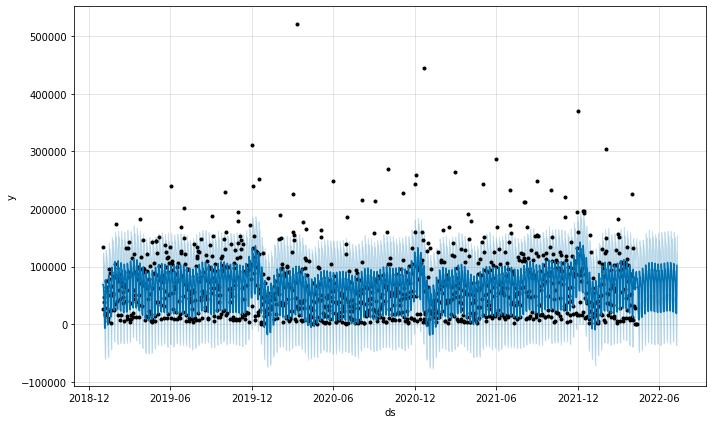

In [594]:
fig1 = p.plot(forecast)

In [595]:
pd.options.display.float_format = '{:.3f}'.format
forecast[['yhat']].iloc[-90:].sum()

yhat   6107392.231
dtype: float64

**Daqui 90 dias, os senadores irão gastar aproximadamente 6 milhões de reais!**

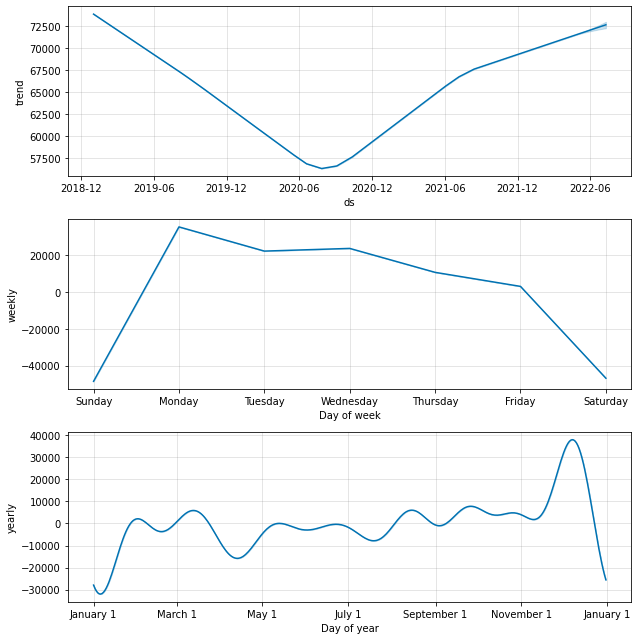

In [596]:
fig2 = p.plot_components(forecast)

* A tendência é que os gastos aumentem daqui 3 meses.
* Os gastos diários na segunda-feira começam altos e diminuem conforme passa a semana. 
* No final do ano, os gastos diários ultrapassam 100 mil reais por dia.


# Diagnóstico

## Validação Cruzada

In [597]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [600]:
df_cv = cross_validation(p, initial='720 days', period='15 days', horizon='90 days')

INFO:fbprophet:Making 26 forecasts with cutoffs between 2021-01-02 00:00:00 and 2022-01-12 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

In [601]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,1844566762.074,42948.420,29963.263,0.762,0.382,0.834
1,10 days,1669837804.063,40863.649,28506.037,0.781,0.382,0.852
2,11 days,1328393489.334,36447.133,25721.680,0.779,0.373,0.889
3,12 days,1077627353.235,32827.235,24893.349,0.803,0.416,0.894
4,13 days,1307373179.007,36157.616,26167.834,0.864,0.416,0.885
...,...,...,...,...,...,...,...
77,86 days,1681926759.474,41011.300,28448.911,1.608,0.415,0.868
78,87 days,1442933617.705,37985.966,27349.636,1.603,0.417,0.876
79,88 days,1305419674.518,36130.592,26373.860,1.674,0.404,0.879
80,89 days,1196044683.559,34583.879,26173.497,2.067,0.417,0.879


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


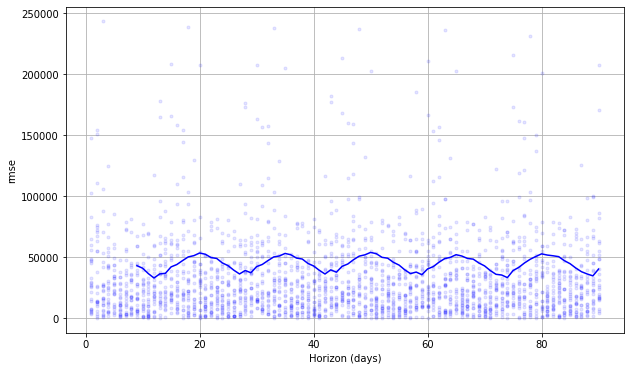

In [604]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

* O modelo teve um rmse de aproximadamente 50 mil reais.

